In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [127]:
df = pd.read_csv('eventDF.csv', index_col=0)
df.head(3)

,Old_ID,ID,AgeSex,Day,Went_From,Went_To,Status,Got_From,Got_At,From_geo,To_geo
0,5,0.0,50F,6,Hefei,Wuhan,0.0,NaN,NaN,"(31.85, 117.28)","(30.58, 114.27)"
1,5,0.0,50F,"(6, 6, 7)",NaN,NaN,1.0,NaN,Wuhan,NaN,NaN
2,5,0.0,50F,7,Wuhan,Hefei,1.0,NaN,NaN,"(30.58, 114.27)","(31.85, 117.28)"


In [128]:
df.ID.nunique()  # how many cases does this include

334

In [129]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1402 entries, 0 to 1401
Data columns (total 11 columns):
Old_ID       1402 non-null object
ID           1390 non-null float64
AgeSex       1402 non-null object
Day          1389 non-null object
Went_From    440 non-null object
Went_To      440 non-null object
Status       1388 non-null float64
Got_From     25 non-null object
Got_At       333 non-null object
From_geo     440 non-null object
To_geo       440 non-null object
dtypes: float64(2), object(9)
memory usage: 131.4+ KB


#### What was the mean status of people who were traveling with the disease?  So we're just looking at the 1's and 2's here.

In [163]:
sick_travels = df[(df.Status > 0) & (df.Status < 3) & (df.Went_From.notnull())]
sick_travels.groupby('ID').mean().mean()

Status    1.20116
dtype: float64

So about 20% of the people were traveling after they already had symptoms, while the other 80% had been infected but felt fine, or at least claimed so.  I grouped by patient and took the mean of the mean of each patient's travel statuses because many patients had multiple travel legs and I didn't want those patients' cases to carry more weight than patients with just one travel leg.

#### When did those 2's happen, compared to the 1's?

In [131]:
# Let's see what type of values we're dealing with here first
sick_travels.Day.values[100:130]

array(['18', '18', '6', '6', '18', '22', '22', '22', '22', '22', '22',
       '9', '19', '22', '20', '8', '21', '21', '13', '15', '15', '13',
       '13', '(14, 17)', '(14, 17)', '(0, 18, 19)', '19', '6', '18', '20'],
      dtype=object)

String floats mixed with string repr of 2- and 3-tuples:  It made life easier while not discarding any info, during data entry, but now needs a little regex to tidy up.

In [132]:
import re
def floatize(day):
    ''' Helper func to convert strings of numbers and strings of 2- and 3- tuples into single floats'''
    if str(day)[0] != '(':
        return float(day)
    days = re.findall(r'[0-9]+', day)  ## convert """  '(20,24,25)'  """ into """  ['20', '24', '25']  """
    if len(days) == 3:
        return float(days[1])  # that's the best-guess day in the 3-tuples
    if len(days) == 2:
        return sum(float(d) for d in days) / 2
    return np.nan

In [164]:
sick_travels['Float_Day'] = sick_travels.Day.apply(floatize)

/Users/ethanhaley/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [156]:
# how many legs of travel, on avg, does a patient have here?
len(sick_travels) / sick_travels.ID.nunique()

1.3132911392405062

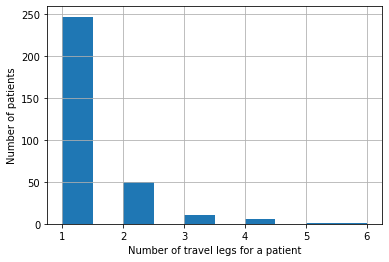

In [33]:
sick_travels.groupby('ID').size().hist()
plt.xlabel('Number of travel legs for a patient')
plt.ylabel('Number of patients');

So let's just look at each travel leg as a point on its own, regardless of whether the traveler had 4 points or 1.

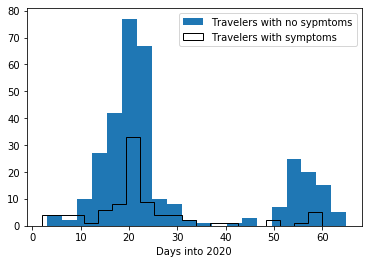

In [223]:
asymp = sick_travels[sick_travels.Status == 1]
symp = sick_travels[sick_travels.Status == 2]
asymp['Float_Day'].hist(bins=20, label='Travelers with no sypmtoms')
symp['Float_Day'].hist(histtype='step', color='k', bins=20, label='Travelers with symptoms')
plt.legend()
plt.grid(False)
plt.xlabel('Days into 2020')
plt.savefig('Distr_symp_vs_asymp.png');


In [34]:
print('===> mean day of travel for patients with no symptoms: ' + str(asymp['Float_Day'].mean()))
print('...and for patients with symptoms: ' + str(symp['Float_Day'].mean()))
      

===> mean day of travel for patients with no symptoms: 28.01851851851852
...and for patients with symptoms: 23.06179775280899


It looks as though during February, people were becoming aware enough of the contagiousness of cov-19 that they were not traveling as much once they had symptoms (or they weren't being allowed to).  Also of note are the peaks in both types of travelers just after 20 January.  Partly it's just a function of the fact that the virus was spreading rapidly in China in mid-January, so much so that China shut down travel to and from Wuhan on January 22nd, leading to the sudden dropoff in sick travelers on the chart.  But the chart also suggests that people caught wind of the imminent Wuhan shutdown and made a last-ditch effort, knowingly sick or not, to flee to their hometowns before it was too late.  The evidence for that lies in the ratio of symptomatic travelers to asymptomatic ones in the prior week, where the ratio appears to be less than 1 to 4, compared to the ratio on 20-21 Jan, where it spikes up to maybe 3 to 7. Let's see the actual data:

In [35]:
jan13to19symp = symp[(symp.Float_Day >= 13) & (symp.Float_Day < 20)]
jan13to19asymp = asymp[(asymp.Float_Day >= 13) & (asymp.Float_Day < 20)]
jan20to21symp = symp[(symp.Float_Day >= 20) & (symp.Float_Day < 22)]
jan20to21asymp = asymp[(asymp.Float_Day >= 20) & (asymp.Float_Day < 22)]

print('The proportion of sick travelers who were symptomatic in the week before 20 Jan:')
print(np.round(len(jan13to19symp) / (len(jan13to19asymp) + len(jan13to19symp)), 2))
print()
print('The proportion of sick travelers who were symptomatic on 20-21 Jan:')
print(np.round(len(jan20to21symp) / (len(jan20to21asymp) + len(jan20to21symp)), 2))

The proportion of sick travelers who were symptomatic in the week before 20 Jan:
0.13

The proportion of sick travelers who were symptomatic on 20-21 Jan:
0.28


Just curious how these numbers change if the approximated days of travel aren't included:

In [36]:
approx = sick_travels.Day.str.startswith('(')
not_approx = sick_travels[~approx]
not_approx['Int_Day'] = [int(d) for d in not_approx.Day]

exact_asymp = not_approx[not_approx.Status == 1]
exact_symp = not_approx[not_approx.Status == 2]
print('===> mean day of travel for patients with no symptoms: ' + str(exact_asymp['Int_Day'].mean()))
print('...and for patients with symptoms: ' + str(exact_symp['Int_Day'].mean()))
print('(vs. 28.02 and 23.06 with approximate dates included)')

===> mean day of travel for patients with no symptoms: 28.414790996784564
...and for patients with symptoms: 22.65
(vs. 28.02 and 23.06 with approximate dates included)


/Users/ethanhaley/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


#### We should test the null hypothesis on those numbers

First check the null hypothesis that sick people with symptoms continued to travel just as much as sick people without symptoms, throughout the travel period covered by the data here.

Check 10,000 random permutations of the travel events to see how likely the null hypothesis is.

In [165]:
n = len(asymp)
days = np.copy(sick_travels.Float_Day.values)  # if you don't clone this, the df column will get mangled by np.shuffle
# take 10000 randomly permuted split samples of the days and see how many have > 5 days difference between the sample means
diffs = []
for _ in range(10000):
    np.random.shuffle(days)
    diffs.append(np.mean(days[:n]) - np.mean(days[n:]))

print('p-value for the null hypothesis, given the difference between the means: ')
observed_diff = 28.02 - 23.06
print(sum(np.array(diffs) >= observed_diff) / 10000)

p-value for the null hypothesis, given the difference between the means: 
0.0026


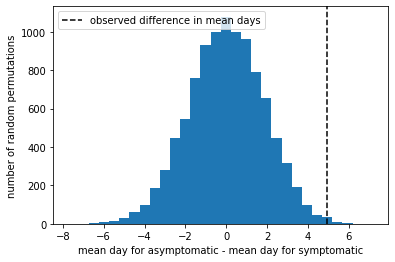

In [166]:
plt.hist(diffs, bins=30)
plt.axvline(observed_diff, linestyle='--', color='k', label='observed difference in mean days')
plt.legend()
plt.xlabel('mean day for asymptomatic - mean day for symptomatic')
plt.ylabel('number of random permutations');

Unless someone demands an unusually high significance level for this test, that p-value is small enough to reject the null hypothesis and accept the alternative, which is that people with symptoms were either intentionally avoiding travel, or perhaps being required to do so, as time increased.  Nevertheless, amidst that overall trend, there's an opposing trend on a smaller scale, where the proportion of sick travelers who were symptomatic rose from 0.13 in the week before 20 Jan to 0.28 on 20-21 Jan, probably due to the impending Wuhan lockdown.  

Even ignoring the more general trend, which would suggest this rise in proportion is unlikely, let's see how unlikely it is.  The null hypothesis will be that the sick travelers on these 9 days are randomly distributed, such that the increase in proportions of symptomatic travelers has a true mean of 0 and a standard deviation large enough that the increase we actually see, 0.15, is not statistically significant.  I'll start by claiming that any increase beyond 1.64 standard devs is enough to reject that null hypothesis, since less than 5% of random permutations should show that large of an increase.

In [40]:
n_symp = len(jan13to19symp) + len(jan20to21symp)  # total number of symptomatic in these 9 days
n_asymp = len(jan13to19asymp) + len(jan20to21asymp)  # total number of asymptomatic in these 9 days
print(f'Total number of travel legs for 13-21 Jan:  {n_symp + n_asymp}')
n_13_to_19 = len(jan13to19symp) + len(jan13to19asymp)  # all travels jan.13-19
n_20_to_21 = len(jan20to21symp) + len(jan20to21asymp)  # all travels jan.20-21
print(f'{n_13_to_19} of them Jan.13-19 and {n_20_to_21} of them Jan.20-21')

Total number of travel legs for 13-21 Jan:  179
110 of them Jan.13-19 and 69 of them Jan.20-21


In [41]:
had_symp = np.array([0] * n_asymp + [1] * n_symp)
n_trials = 10000
diffs = np.empty(n_trials)
for i in range(n_trials):
    had_symp = np.random.permutation(had_symp) # shuffle them
    post = sum(had_symp[n_13_to_19:]) / n_20_to_21  # proportion symptomatic for 2nd period
    pre = sum(had_symp[:n_13_to_19]) / n_13_to_19  # proportion symptomatic for 1st period
    diffs[i] = post - pre   # the statistic being calculated and tested

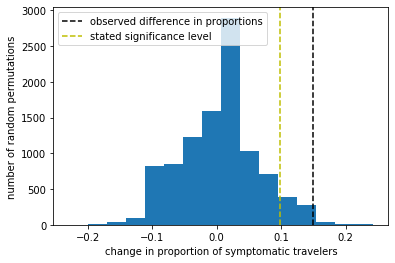

In [42]:
observed_diff = 0.28 - 0.13   # the actual increase in proportion from the 1st period to the second
plt.hist(diffs, bins=16)  # higher numbers of bins had empty bins that were confusing
plt.axvline(observed_diff, linestyle='--', color='k', label='observed difference in proportions')
plt.axvline(np.std(diffs) * 1.64, linestyle='--', color='y', label='stated significance level')
plt.legend()
plt.xlabel('change in proportion of symptomatic travelers')
plt.ylabel('number of random permutations');

Since the observed difference is to the right of the stated significance level, we know the p-value is less than 0.05, we can reject the null hypothesis, and we can be confident that there's a reason more people are traveling when they know they're sick on 20-21 Jan.   The part of this analysis that's somewhat questionable is that it smacks of the "Texas Sharpshooter" phenomenon, since I began by focusing on a specific part of the data that seemed interesting, and then I drew a circle around the perfect dates that perhaps minimized p-values for the null hypothesis.  What I would say in my defense is that the dates before the selected ones contain very few cases, and indeed the symptomatic travelers at that point most likely had no idea their symptoms might be from covid-19 (The Chinese government only announced the existence of the new coronavirus on 7 Jan).  Also in my defense, the most likely underlying cause for the data I circled--the Wuhan shutdown--draws its own endpoint in time, on 22 January.  And finally, as I pointed out, this analyzed trend runs counter to the overall trend, which makes it inherently less likely and more worth exploring.

## Next, let's see if travelers are reporting their symptoms later than non-travelers

The idea is to see if there's some kind of difference in the time between STATED onset of symptoms until hospital admission, for people who traveled vs people who didn't. Here are some potential underlying reasons:  People who don't travel could be more inclined to list their symptom onset sooner, but they also might wait longer to go to the hospital, being in the safety of their homes and knowing the hospital was nearby if absolutely necessary. Either one of those proving to be true, the difference in dates should be longer for them vs. for travelers. Travelers might not want to believe or admit they have symptoms, thus stating the max possible date for that, but their hospital visit might go either way: No one wants to be stuck in a foreign hospital, to miss the balance of their vacation, or to deal with the financial costs of rescheduling their return home, so they're more likely to ignore warning signs while traveling. On the other hand, if they started feeling a little sick BEFORE their travels started, they might have decided to plow onward optimistically, only to find themselves in dire straits on vacation, and perhaps paranoid about what they're hearing about coronavirus, to the extent that they visit a doctor while traveling.

Start with all of the the cases reported as of now, April 20:

In [177]:
updated = pd.read_csv('https://github.com/beoutbreakprepared/nCoV2019/raw/master/latest_data/latestdata.csv',
                     low_memory=False) # low_memory keyword arg suppresses the warning

In [178]:
updated.shape

(432704, 33)

In [179]:
updated.columns

Index(['ID', 'age', 'sex', 'city', 'province', 'country', 'latitude',
       'longitude', 'geo_resolution', 'date_onset_symptoms',
       'date_admission_hospital', 'date_confirmation', 'symptoms',
       'lives_in_Wuhan', 'travel_history_dates', 'travel_history_location',
       'reported_market_exposure', 'additional_information',
       'chronic_disease_binary', 'chronic_disease', 'source',
       'sequence_available', 'outcome', 'date_death_or_discharge',
       'notes_for_discussion', 'location', 'admin3', 'admin2', 'admin1',
       'country_new', 'admin_id', 'data_moderator_initials',
       'travel_history_binary'],
      dtype='object')

Split into the two groups

In [180]:
travelers = updated[updated.travel_history_dates.notnull()]
travelers.shape

(2132, 33)

In [181]:
nontravelers = updated[updated.travel_history_dates.isnull()]
nontravelers.shape

(430572, 33)

Filter down to the ones whose symptom onset date is reported

In [182]:
travdetes = travelers[travelers.date_onset_symptoms.notnull()]
travdetes.shape

(1383, 33)

In [183]:
nontravdetes = nontravelers[nontravelers.date_onset_symptoms.notnull()]
nontravdetes.shape

(2874, 33)

Filter down to the ones who have hospital admission dates

In [184]:
hosptrav = travdetes[travdetes.date_admission_hospital.notnull()]
hosptrav.shape

(601, 33)

In [185]:
hospnontrav = nontravdetes[nontravdetes.date_admission_hospital.notnull()]
hospnontrav.shape

(796, 33)

601 travelers with dates listed and 796 non-travelers

[sidenote about what just happened:  If I'd waited till after filtering to split travelers vs non-, it would've involved less work, or "fewer chances to make mistakes", if you prefer]

In [188]:
# parse dates into pandas datetimes and calulate their diffs
travdates = zip(hosptrav.date_onset_symptoms, hosptrav.date_admission_hospital)
diffs = []  # store the differences between onset and hospital for each traveler
errors = []   # if anything goes wrong with parsing dates, for debugging
for td in travdates:
    try:
        d1 = pd.Timestamp('-'.join(td[0].split('.')[::-1]))  # reverse date format for pandas
        d2 = pd.Timestamp('-'.join(td[1].split('.')[::-1]))   # i.e. '24.02.2020' ==> '2020-02-24'
        diffs.append((d2 - d1) / pd.Timedelta('1D'))
    except ValueError:
        errors.append(td)
errors                          

[]

In [189]:
# now the non-travelers
nontravdates = zip(hospnontrav.date_onset_symptoms, hospnontrav.date_admission_hospital)
diffs2 = []
errors2 = []
for td in nontravdates:
    try:
        d1 = pd.Timestamp('-'.join(td[0].split('.')[::-1]))
        d2 = pd.Timestamp('-'.join(td[1].split('.')[::-1]))
        diffs2.append((d2 - d1) / pd.Timedelta('1D'))
    except ValueError:
        errors2.append(td)
errors2

[('08.03.20202', '09.03.2020'),
 ('10.01.2020 - 22.01.2020', '18.01.2020 - 23.01.2020'),
 ('10.01.2020 - 22.01.2020', '18.01.2020 - 23.01.2020'),
 ('10.01.2020 - 22.01.2020', '18.01.2020 - 23.01.2020'),
 ('10.01.2020 - 22.01.2020', '18.01.2020 - 23.01.2020'),
 ('10.01.2020 - 22.01.2020', '18.01.2020 - 23.01.2020'),
 ('01.31.2020', '03.02.2020'),
 ('08.03.20202', '09.03.2020'),
 ('10.01.2020 - 22.01.2020', '18.01.2020 - 23.01.2020'),
 ('10.01.2020 - 22.01.2020', '18.01.2020 - 23.01.2020'),
 ('10.01.2020 - 22.01.2020', '18.01.2020 - 23.01.2020'),
 ('10.01.2020 - 22.01.2020', '18.01.2020 - 23.01.2020'),
 ('10.01.2020 - 22.01.2020', '18.01.2020 - 23.01.2020'),
 ('01.31.2020', '03.02.2020')]

Looks like cases are all duplicated in the dataset, based on the errors2 list.  Let's see....

In [191]:
# Using age, sex, city, onset_date, and hospital_date should make everyone unique without erasing uniques
dedupetravs = hosptrav.drop_duplicates(subset=['age', 'sex', 'city', 'date_onset_symptoms',
                                               'date_admission_hospital'])
dedupetravs.shape  # down from 601

(304, 33)

In [192]:
dedupenontravs = hospnontrav.drop_duplicates(subset=['age', 'sex', 'city', 'date_onset_symptoms',
                                               'date_admission_hospital'])
dedupenontravs.shape  # down from 796

(418, 33)

In [211]:
# parse dates into pandas datetimes and calulate their diffs
travdates = zip(dedupetravs.date_onset_symptoms, dedupetravs.date_admission_hospital)
diffs3 = []  # store the differences between onset and hospital for each traveler
errors3 = []   # if anything goes wrong with parsing dates, for debugging
for td in travdates:
    try:
        d1 = pd.Timestamp('-'.join(td[0].split('.')[::-1]))  # reverse date format for pandas
        d2 = pd.Timestamp('-'.join(td[1].split('.')[::-1]))   # i.e. '24.02.2020' ==> '2020-02-24'
        diffs3.append((d2 - d1) / pd.Timedelta('1D'))
    except ValueError:
        errors3.append(td)
errors3  

[]

In [212]:
# now the non-travelers
nontravdates = zip(dedupenontravs.date_onset_symptoms, dedupenontravs.date_admission_hospital)
diffs4 = []
errors4 = []
for td in nontravdates:
    try:
        d1 = pd.Timestamp('-'.join(td[0].split('.')[::-1]))
        d2 = pd.Timestamp('-'.join(td[1].split('.')[::-1]))
        diffs4.append((d2 - d1) / pd.Timedelta('1D'))
    except ValueError:
        errors4.append(td)
errors4

[('08.03.20202', '09.03.2020'),
 ('10.01.2020 - 22.01.2020', '18.01.2020 - 23.01.2020'),
 ('10.01.2020 - 22.01.2020', '18.01.2020 - 23.01.2020'),
 ('01.31.2020', '03.02.2020')]

Quick look at the distributions to check if anything else looks wrong

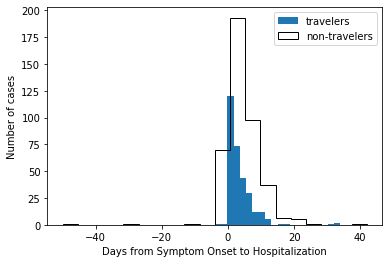

In [213]:
plt.hist(diffs3, bins=20, label='travelers')
plt.hist(diffs4, histtype='step', color='k', bins=20, label='non-travelers')
plt.xlabel('Days from Symptom Onset to Hospitalization')
plt.ylabel('Number of cases')
plt.legend();

In [214]:
print(len(diffs3), len(diffs4))

304 414


The outlier bins are distorting the others.  Could be some typos in the dates causing those bigger outliers, or maybe just strange circumstances for the case.  If someone was hospitalized before they had symptoms, their case won't help determine anything here, so I'll drop all negative diffs.  As for the cases where someone ended up in the hospital 40 days after onset of symptoms, I'm going to somewhat arbitrarily choose to drop those as well.  They are more likely to distort the potential findings of the analysis than to actually represent some kind of trend or lack thereof.  So I'll remove anything over 20 days diff.

In [217]:
diffs3 = np.array(diffs3)
diffs4 = np.array(diffs4)
diffs3 = diffs3[(diffs3 >= 0) & (diffs3 <= 20)]
diffs4 = diffs4[(diffs4 >= 0) & (diffs4 <= 20)]
print(len(diffs3), len(diffs4))

298 401


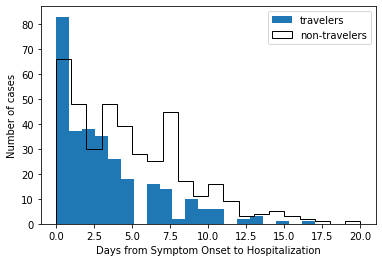

In [229]:
plt.hist(diffs3, bins=20, label='travelers')
plt.hist(diffs4, histtype='step', color='k', bins=20, label='non-travelers')
plt.xlabel('Days from Symptom Onset to Hospitalization')
plt.ylabel('Number of cases')
plt.legend()
plt.savefig('Days_Symp_Hosp.png');

In [219]:
print(f'The mean amount of days between symptom onset and hospital admission for non-travelers was {np.mean(diffs4)}')
print(f'For travelers it was {np.mean(diffs3)}')

The mean amount of days between symptom onset and hospital admission for non-travelers was 4.43640897755611
For travelers it was 3.1308724832214767


Test the null hypothesis, that there's no underlying factor causing the difference in means between travelers and non-travelers. Even though it's obvious from that histogram, that travelers who get to the hospital and say "The symptoms just showed up" outnumber such non-travelers, despite  there being fewer travelers in this data sample. 

In [220]:
n_travs = len(diffs3)
n_nontravs = len(diffs4)
meandiff = np.mean(diffs4) - np.mean(diffs3)
alldiffs = np.append(diffs3, diffs4)
samplediffs = []
for _ in range(10000):
    shuffled = np.random.permutation(alldiffs)
    samplediffs.append(np.mean(shuffled[:n_nontravs]) - np.mean(shuffled[n_nontravs:]))

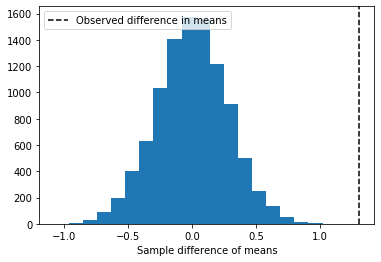

In [221]:
plt.hist(samplediffs, bins=20)
plt.axvline(meandiff, color='k', linestyle='--', label='Observed difference in means')
plt.xlabel('Sample difference of means')
plt.legend();

In [222]:
len(np.where(samplediffs > meandiff))

1

1 out of 10,000 simulations of random permutations had a greater mean diff than the actual one, so let's call the p-value of the null hypothesis 0.0001 and reject it.

The more you look at these sick traveler cases, the more you realize just how dangerous they are:  

    1) People are spreading the disease between communities, increasing the odds of a pandemic.  
    
    2) They're claiming over 1 day less of being symptomatic before going to the hospital than are non-travelers.  
        Unless you want to believe that they're just a more cautious group of people, or are more
        worried about their symptoms just by virtue of having traveled, the most likely explanation is
        that they want to report their symptom onset later than it actually happened, perhaps because they 
        know how dangerous their actions may be perceived.  
        
    3) The standard modes of transportation bring many travelers together in close quarters, making airborne
        and surface-borne diseases especially contagious.  And the part of this disease's lifecycle when the
        patient is most contagious is at or near this point when symptoms first appear.  
   [Link to source article about contagiousness for COVID-19](https://www.nature.com/articles/s41591-020-0869-5)
    

I'm not claiming travel is bad just because it's dangerous, and I'm also not claiming people are bad for trying to believe their symptoms actually showed up the second their flight home landed.  Besides the fact that people are only human, there's the fact that "When did you first have symptoms?" is sometimes very hard to answer accurately.  So all I can do is point out the obvious fact that we need better screening of travelers, preferably before they board planes, trains, buses, and boats.  Better than testing their forehead temperature after their trip is over, when they might have taken antipyretics to reduce their fevers.  Or maybe we need to make it easier for people to get money back when they cancel travel plans at the last second, thinking they may possibly be sick.  We've seen the alternative, and it's more costly than any preventative measures like these.

At the very least, the data explored here provide statistical support for what you probably already suspected:  People will place their society at greater risk, if doing so makes themselves feel more secure.  And scientific findings that rely upon people stating when they first experienced symptoms are built on shaky ground, especially if a large proportion of the people are travelers, as in the case of this pandemic.  The peer-reviewed source article linked to above studies the question of when a COVID-19 patient is most infectious.  The question has a huge bearing on how we go about dealing with the pandemic, and the article's researchers conclude that a patient is likely most  infectious just before his own symptom onset.  Yet they end their argument by pointing out that if people tend to state onset dates that are later than actual onset dates, the point of maximum contagiousness moves later in time.  Considering the huge ramifications and the data presented here, we should assume that this is the case.